In [266]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from scipy.interpolate import RegularGridInterpolator

In [267]:
img = fits.getdata('/home/borge/Data/Test_batch/588017702930022421ra.fits.gz')

In [268]:
# some very rough guesses for this galaxy
x0, y0 = (190, 140)
pa = 0.6 # radians
q = 0.7

In [269]:
y, x = np.indices(img.shape)

In [270]:
x -= x0
y -= y0
print(x,y)

[[-190 -189 -188 ...  219  220  221]
 [-190 -189 -188 ...  219  220  221]
 [-190 -189 -188 ...  219  220  221]
 ...
 [-190 -189 -188 ...  219  220  221]
 [-190 -189 -188 ...  219  220  221]
 [-190 -189 -188 ...  219  220  221]] [[-140 -140 -140 ... -140 -140 -140]
 [-139 -139 -139 ... -139 -139 -139]
 [-138 -138 -138 ... -138 -138 -138]
 ...
 [ 141  141  141 ...  141  141  141]
 [ 142  142  142 ...  142  142  142]
 [ 143  143  143 ...  143  143  143]]


In [271]:
# this is well tested code to deproject x, y
ct = np.cos(-pa)
st = np.sin(-pa)
xp = (y * ct + x * st) / q
yp = (-y * st + x * ct)
rp2 = xp ** 2 +  yp ** 2
rp = np.sqrt(rp2)
tp = np.arctan2(yp, xp)

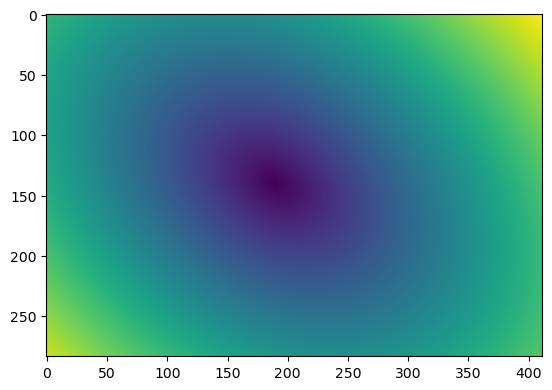

In [272]:
plt.imshow(rp);

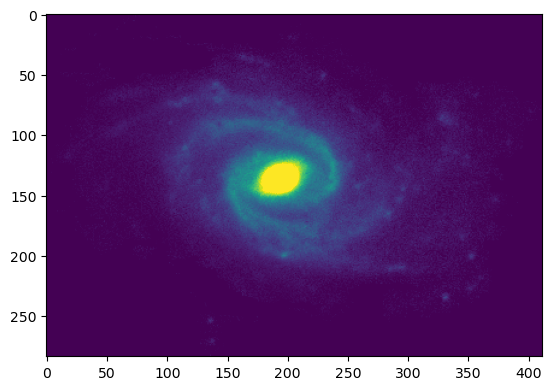

In [273]:
plt.imshow(img, vmin=1000, vmax=1300);

In [274]:
n_lnr = 150
n_theta = 150
lnr, theta = np.indices((n_lnr, n_theta))

In [275]:
lnr_min = 3.7
lnr_max = 5.0
theta_max = 360
lnr = (lnr / n_lnr) * (lnr_max - lnr_min) + lnr_min
theta = theta * theta_max / n_theta

In [276]:
xp = np.exp(lnr) * np.sin(np.radians(theta))
yp = np.exp(lnr) * np.cos(np.radians(theta))
print(xp,yp)

[[  0.           1.69375731   3.3845432  ...  -5.06939144  -3.3845432
   -1.69375731]
 [  0.           1.70850034   3.41400338 ...  -5.11351711  -3.41400338
   -1.70850034]
 [  0.           1.72337169   3.44372    ...  -5.15802685  -3.44372
   -1.72337169]
 ...
 [  0.           6.05539326  12.1001633  ... -18.12370554 -12.1001633
   -6.05539326]
 [  0.           6.1081014   12.20548712 ... -18.28146027 -12.20548712
   -6.1081014 ]
 [  0.           6.16126834  12.31172772 ... -18.44058815 -12.31172772
   -6.16126834]] [[ 40.44730436  40.4118252   40.30544997 ...  40.12836528  40.30544997
   40.4118252 ]
 [ 40.79937108  40.7635831   40.65628195 ...  40.47765586  40.65628195
   40.7635831 ]
 [ 41.15450231  41.11840282  41.01016768 ...  40.82998677  41.01016768
   41.11840282]
 ...
 [144.60414867 144.47730627 144.09700157 ... 143.46390177 144.09700157
  144.47730627]
 [145.86283104 145.73488456 145.35126956 ... 144.71265905 145.35126956
  145.73488456]
 [147.1324694  147.00340922 146.61645

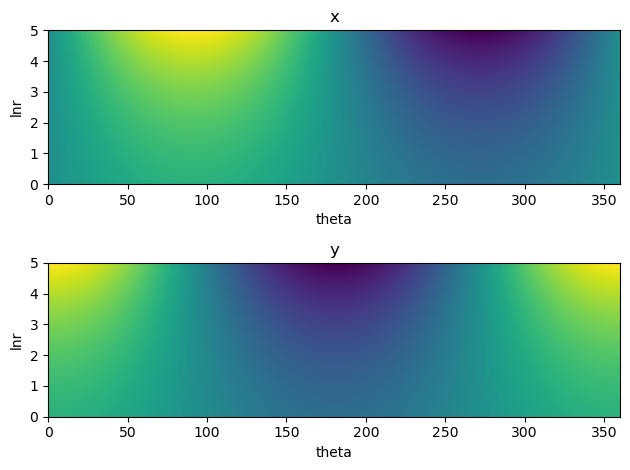

In [277]:
fig, ax = plt.subplots(2)
ax[0].imshow(xp, extent=(0, theta_max, 0, lnr_max), origin='lower', aspect='auto')
ax[1].imshow(yp, extent=(0, theta_max, 0, lnr_max), origin='lower', aspect='auto')
ax[0].set_title('x')
ax[1].set_title('y');
for a in ax:
    a.set_xlabel('theta')
    a.set_ylabel('lnr');
plt.tight_layout()

In [278]:
# this is an attempt at using the above deprojection code
# to do the inverse by pa -> -pa and q -> 1/q
ct = np.cos(pa)
st = np.sin(pa)
x = (yp * ct + xp * st) * q
y = (-yp * st + xp * ct)
x += y0
y += x0

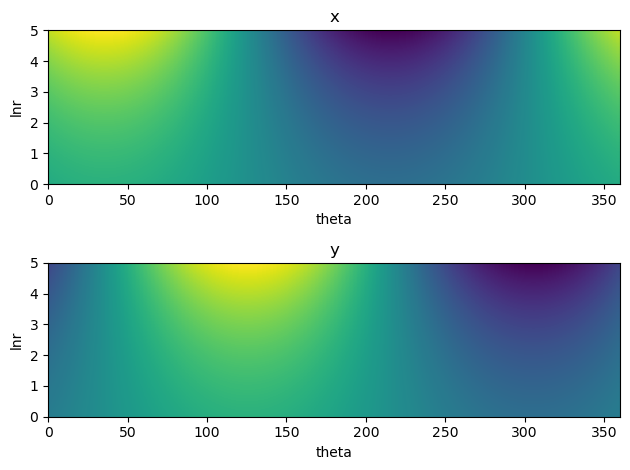

In [279]:
fig, ax = plt.subplots(2)
ax[0].imshow(x, extent=(0, theta_max, 0, lnr_max), origin='lower', aspect='auto')
ax[1].imshow(y, extent=(0, theta_max, 0, lnr_max), origin='lower', aspect='auto')
ax[0].set_title('x')
ax[1].set_title('y');
for a in ax:
    a.set_xlabel('theta')
    a.set_ylabel('lnr');
plt.tight_layout()

In [280]:
img_interp = RegularGridInterpolator((np.arange(img.shape[0]), np.arange(img.shape[1])), img)

In [281]:
ok = (x >= 0) & (x < img.shape[0] - 1)
ok &= (y >= 0) & (y < img.shape[1] - 1)

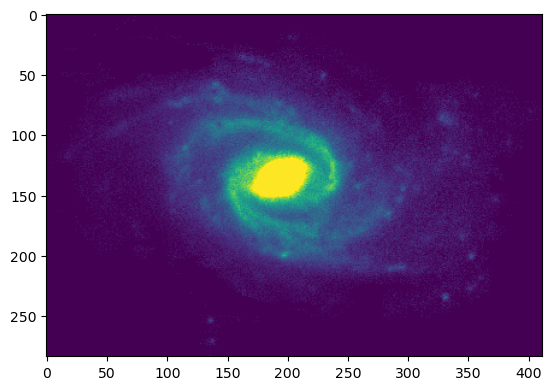

In [282]:
plt.imshow(img, vmin=1000, vmax=1200);

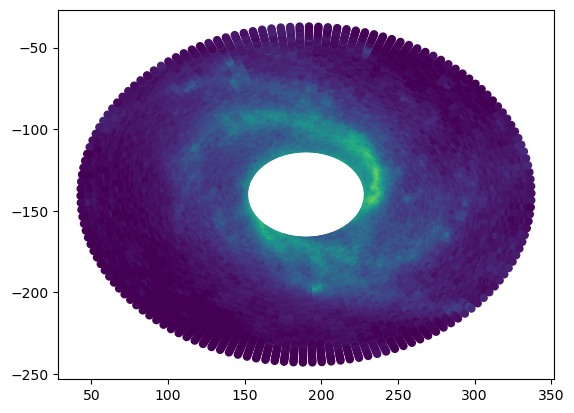

In [283]:
plt.scatter(y[ok], -x[ok], c=img_interp((x[ok], y[ok])),
            vmin=1000, vmax=1200, s=25);

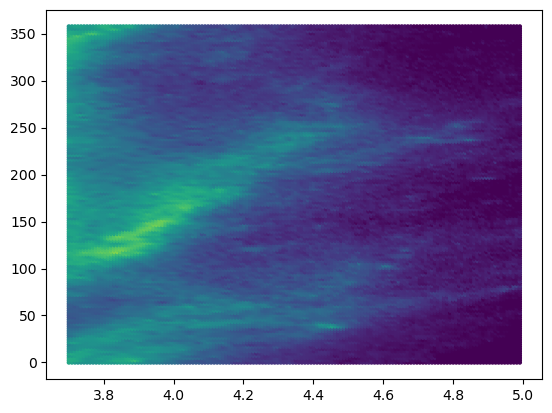

In [284]:
plt.scatter(lnr[ok], theta[ok], c=img_interp((x[ok], y[ok])),
            vmin=1000, vmax=1200, s=5);

(150, 150) (150, 150)


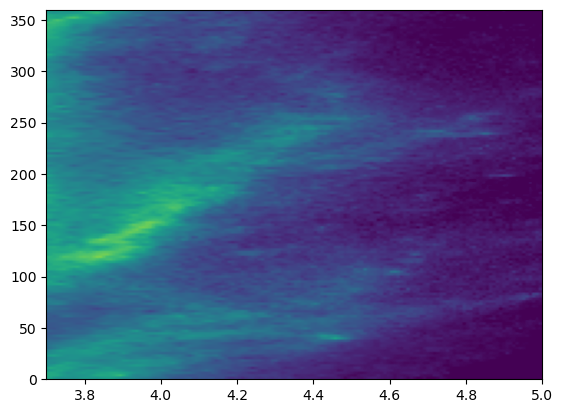

In [285]:
img_lnr_theta = img_interp((x, y))
plt.imshow(img_lnr_theta.T, vmin=1000, vmax=1200,
           extent=(lnr_min, lnr_max, 0, theta_max),
           origin='lower', aspect='auto');
print(x.shape,y.shape)

In [286]:
# use broadcasting to do multiple p at once
p = np.arange(-25, 25, 0.1).reshape((-1, 1, 1))

In [287]:
m = 2
weight = np.exp(1j*(m * np.radians(theta) + lnr * p))
D = img_lnr_theta.sum()

In [288]:
A = abs((img_lnr_theta * weight).sum((-1, -2)))
p_max = p.ravel()[A.argmax()]
p_max

-3.599999999999696

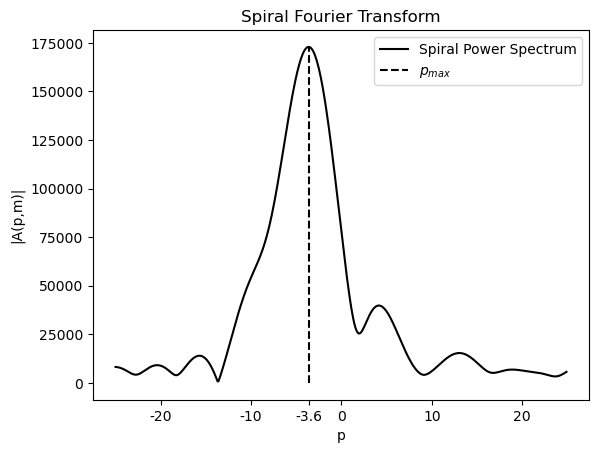

In [303]:
plt.figure()
plt.plot(p.ravel(), A,'k')
plt.vlines(p_max,0,np.max(A),'k','dashed','$p_(max)$')
plt.legend(['Spiral Power Spectrum','$p_{max}$'])
plt.title('Spiral Fourier Transform')
plt.xlabel('p')
plt.xticks([-20,-10,p_max,0,10,20],['-20','-10','-3.6','0','10','20'])
plt.ylabel('|A(p,m)|');


In [304]:
p_max = p.ravel()[A.argmax()]
p_max

-3.599999999999696

In [305]:
phi = np.degrees(np.arctan(-m/p_max))
phi

29.0546040990792